# Desafio Alura Store – Análise das Lojas

## 0. Contexto do Projeto

O Senhor João é dono de uma rede de lojas chamada **Alura Store** e deseja vender **uma das 4 lojas** para investir em um novo empreendimento.

O objetivo deste projeto é, a partir dos dados históricos de vendas, responder:

> **“Qual loja da Alura Store o João deve vender?”**

Para isso, vamos analisar:
- **Faturamento**
- **Categorias mais vendidas**
- **Produtos mais vendidos**
- **Avaliação dos clientes**
- **Frete médio**

No final, apresentamos uma **recomendação clara**, baseada nos dados.

---


## 1. Setup inicial e importação dos dados

### Importação dos dados



In [179]:
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid") # Deixa o fundo branco com linhas suaves


In [153]:
# Pasta onde estão os CSVs das lojas
pasta_raw = Path("../data/raw")

# Lista de caminhos dos arquivos de loja
caminhos = sorted(pasta_raw.glob("loja_*.csv"))

tabelas_loja = []

for i, caminho in enumerate(caminhos, start=1):
    df = pd.read_csv(caminho)
    df["Loja"] = f"Loja {i}"
    tabelas_loja.append(df)

print("Total de DataFrames lidos:", len(tabelas_loja))
tabelas_loja[0].head(2)

Total de DataFrames lidos: 4


,Produto,Categoria do Produto,Preço,Frete,Data da Compra,Vendedor,Local da compra,Avaliação da compra,Tipo de pagamento,Quantidade de parcelas,lat,lon,Loja
0,Assistente virtual,eletronicos,219.08,9.249790,16/01/2021,Pedro Gomes,SP,4,cartao_credito,8,-22.19,-48.79,Loja 1
1,Mesa de jantar,moveis,256.35,11.234305,18/05/2022,Beatriz Moraes,RJ,1,cartao_credito,4,-22.25,-42.66,Loja 1


## 2. Consolidação e Tratamento dos Dados


### 2.1 Unir as lojas em uma única base (`dados`)


In [154]:
# agora vamos empilhar (juntar) as 4 tabelas em uma só

dados = pd.concat(tabelas_loja, ignore_index=True) # ignore_index=True cria um novo índice sequencial (0,1,2,...) sem repetir

# conferimos o tamanho total da tabela final
print("Formato total:", dados.shape)

# verificamos quantas linhas pertencem a cada loja
print(dados["Loja"].value_counts())

#Verificar os valores distintos
print(dados["Loja"].unique())

# olhamos as 3 primeiras linhas para validar a estrutura final
dados.head(3)


Formato total: (9435, 13)
Loja
Loja 1    2359
Loja 2    2359
Loja 3    2359
Loja 4    2358
Name: count, dtype: int64
['Loja 1' 'Loja 2' 'Loja 3' 'Loja 4']


,Produto,Categoria do Produto,Preço,Frete,Data da Compra,Vendedor,Local da compra,Avaliação da compra,Tipo de pagamento,Quantidade de parcelas,lat,lon,Loja
0,Assistente virtual,eletronicos,219.08,9.249790,16/01/2021,Pedro Gomes,SP,4,cartao_credito,8,-22.19,-48.79,Loja 1
1,Mesa de jantar,moveis,256.35,11.234305,18/05/2022,Beatriz Moraes,RJ,1,cartao_credito,4,-22.25,-42.66,Loja 1
2,Jogo de tabuleiro,brinquedos,279.51,21.262681,15/03/2021,João Souza,DF,1,cartao_credito,1,-15.83,-47.86,Loja 1


In [155]:
# salvamos "dados" em um arquivo CSV no computador
# 1) Defina a pasta de destino (relativa ao notebook)
pasta = Path("../data/processed")                  # cria um caminho "data" (subpasta)

# 2) Garanta que a pasta exista
pasta.mkdir(exist_ok=True)            # cria a pasta se ela não existir

# 3) Monte o caminho completo do arquivo
arquivo = pasta / "dados_consolidados.csv"

# 4) Salve o DataFrame
dados.to_csv(arquivo, index=False)

# 5) Mostre o caminho absoluto para você saber exatamente onde ficou
print("CSV salvo em:", arquivo.resolve())


CSV salvo em: F:\Meu Drive\WM\Conhecimento\Cursos TI\Alura\ONE\Chalengers\Store\data\processed\dados_consolidados.csv


### 2.2 Padronizar nomes das colunas (snake_case)
- limpar espaços, 
- passar para minúsculo e 
- trocar espaço por "_".


In [156]:
# guardar nomes originais para comparar depois
colunas_originais = list(dados.columns)

# 2) Vamos criar uma nova lista vazia onde colocaremos os nomes padronizados
novos_nomes = []

# 3) Percorremos cada nome de coluna original
for c in dados.columns:
    # 3.1) limpamos espaços, passamos para minúsculo e trocamos espaço por "_"
    c_limpo = c.strip().lower().replace(" ", "_")
    # 3.2) adicionamos esse nome já padronizado na lista
    novos_nomes.append(c_limpo)

# 4) Atribuímos a lista pronta de volta ao DataFrame
dados.columns = novos_nomes

# 5) Conferimos o antes/depois
print("Antes :", colunas_originais)
print("Depois: ",list(dados.columns))


Antes : ['Produto', 'Categoria do Produto', 'Preço', 'Frete', 'Data da Compra', 'Vendedor', 'Local da compra', 'Avaliação da compra', 'Tipo de pagamento', 'Quantidade de parcelas', 'lat', 'lon', 'Loja']
Depois:  ['produto', 'categoria_do_produto', 'preço', 'frete', 'data_da_compra', 'vendedor', 'local_da_compra', 'avaliação_da_compra', 'tipo_de_pagamento', 'quantidade_de_parcelas', 'lat', 'lon', 'loja']


### 2.3 Converter `data_da_compra` para datetime


In [157]:
# 0) Inspecionar o ESTADO ATUAL (antes da mudança)
print("Antes da mudança:", dados["data_da_compra"].dtype)
# Saída esperada: object (string)

# 1) Converter de STRING -> DATETIME
#    dayfirst=True: interpreta '25/03/2024' como 25 de março
#    errors='coerce': datas inválidas viram NaT (nulo temporal)
dados["data_da_compra"] = pd.to_datetime(
    dados["data_da_compra"],
    dayfirst=True,
    errors="coerce",
)

# 2) Verificar o DEPOIS da mudança
print("dtype depois:", dados["data_da_compra"].dtype)  # esperado: datetime64[ns]


Antes da mudança: object
dtype depois: datetime64[ns]


### 2.4 Converter `preço` e `frete` para numérico


In [158]:
# converter para numérico (se existirem)
for col in dados[["preço", "frete"]]:
    if col in dados.columns:
        dados[col] = pd.to_numeric(dados[col], errors="coerce")


    # conferir
print("\nTipos depois:\n", dados[["preço","frete"]].dtypes)
print("\nAmostra depois:\n", dados[["preço","frete"]].head(3))



Tipos depois:
 preço    float64
frete    float64
dtype: object

Amostra depois:
     preço      frete
0  219.08   9.249790
1  256.35  11.234305
2  279.51  21.262681


### 2.5 Diagnosticar e tratar valores nulos

In [159]:
#Quantos vazios existem ANTES do tratamento?
print("Nulos antes:\n", dados.isna().sum())

#mesmo não existindo dados nulos irei fazer o for que substitui
#vazio por zero.
for col in ["preço", "frete"]:
    if col in dados.columns:
        dados[col] = dados[col].fillna(0)


#Quantos vazios existem DEPOIS do tratamento?
print("Nulos depois:\n", dados.isna().sum())


Nulos antes:
 produto                   0
categoria_do_produto      0
preço                     0
frete                     0
data_da_compra            0
vendedor                  0
local_da_compra           0
avaliação_da_compra       0
tipo_de_pagamento         0
quantidade_de_parcelas    0
lat                       0
lon                       0
loja                      0
dtype: int64
Nulos depois:
 produto                   0
categoria_do_produto      0
preço                     0
frete                     0
data_da_compra            0
vendedor                  0
local_da_compra           0
avaliação_da_compra       0
tipo_de_pagamento         0
quantidade_de_parcelas    0
lat                       0
lon                       0
loja                      0
dtype: int64


## 3. Análise Exploratória e KPIs por Loja

Nesta seção vamos analisar as lojas da Alura Store usando alguns indicadores (KPIs):

- Desempenho financeiro
- Mix de produtos e categorias
- Experiência do cliente
- Logística (frete)

O objetivo é entender o desempenho de cada loja para, depois, conseguir compará-las e recomendar qual deve ser vendida.


### 3.1 Desempenho financeiro

Aqui vamos olhar para:

- Faturamento total por loja
- Faturamento mensal (todas as lojas juntas)


#### 3.1.1 Faturamento total por loja


In [160]:

# Garante que a coluna 'receita' existe
if "receita" not in dados.columns:
    dados["receita"] = dados["preço"] + dados["frete"]

dados[["preço", "frete", "receita"]].head()


,preço,frete,receita
0,219.08,9.249790,228.329790
1,256.35,11.234305,267.584305
2,279.51,21.262681,300.772681
3,1009.99,54.667344,1064.657344
4,446.99,26.964689,473.954689


In [161]:
# Calcula faturamento total por loja
faturamento_loja = (
    dados
    .groupby("loja", as_index=False)["receita"]
    .sum()
    .rename(columns={"receita": "faturamento_total"})
)

# Arredonda APENAS o resultado (não mexe em 'dados')
faturamento_loja["faturamento_total"] = faturamento_loja["faturamento_total"].round(2)

faturamento_loja

,loja,faturamento_total
0,Loja 1,1616347.09
1,Loja 2,1567773.22
2,Loja 3,1542047.69
3,Loja 4,1458253.46


<Figure size 800x400 with 0 Axes>

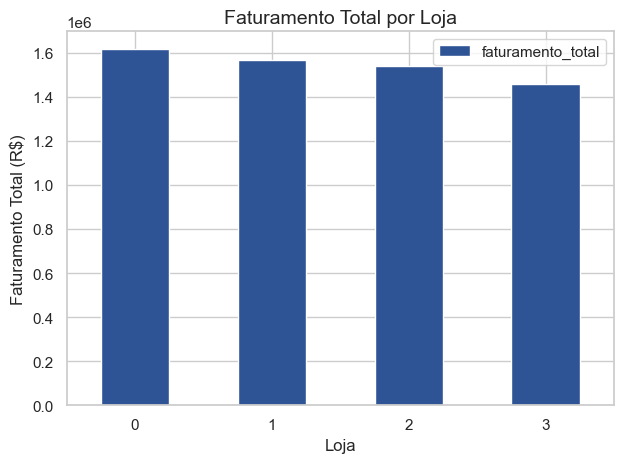

In [ ]:
#Gráfico do faturamento total por loja
plt.figure(figsize=(8, 4))
faturamento_loja.plot(kind="bar", color="#2F5496")
plt.title("Faturamento Total por Loja", fontsize=14)
plt.xlabel("Loja")
plt.ylabel("Faturamento Total (R$)")
plt.xticks(rotation=0)
plt.tight_layout()
# SALVAR A IMAGEM
plt.savefig("../images/faturamento_total_loja.png", dpi=300)
plt.show()


#### 3.1.2 Faturamento mensal (todas as lojas)

In [163]:
# Criaçãp da coluna 'ano_mes'.
if "ano_mes" not in dados.columns:
    dados["ano_mes"] = dados["data_da_compra"].dt.to_period("M").astype(str)

#Faturamento mensal
faturamento_mensal = (
    dados
    .groupby("ano_mes", as_index=False)["receita"]
    .sum()
    .rename(columns={"receita": "faturamento_total"})
)

faturamento_mensal["faturamento_total"] = faturamento_mensal["faturamento_total"].round(2)

faturamento_mensal.head()

,ano_mes,faturamento_total
0,2020-01,150740.46
1,2020-02,151612.49
2,2020-03,169375.05
3,2020-04,191170.08
4,2020-05,171546.25


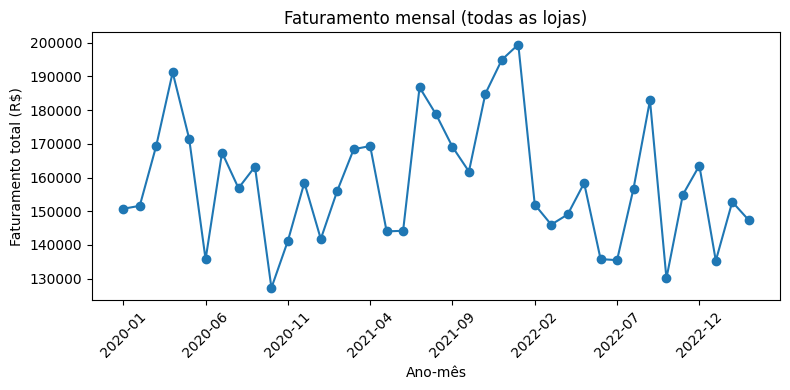

In [164]:
#Gráfico
ax = faturamento_mensal.set_index("ano_mes")["faturamento_total"].plot(
    kind="line",
    marker="o",
    figsize=(8, 4)
)

ax.set_title("Faturamento mensal (todas as lojas)")
ax.set_xlabel("Ano-mês")
ax.set_ylabel("Faturamento total (R$)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.2 Mix de produtos e categorias

Aqui vamos ver:

- Faturamento por categoria
- Quantidade de vendas por categoria
- Produtos mais vendidos e menos vendidos

#### 3.2.1 Faturamento por categoria

In [165]:
faturamento_categoria = (
    dados
    .groupby("categoria_do_produto", as_index=False)["receita"]
    .sum()
    .rename(columns={"receita": "faturamento_total"})
    .sort_values("faturamento_total", ascending=False)
)

faturamento_categoria["faturamento_total"] = faturamento_categoria["faturamento_total"].round(2)

faturamento_categoria.head()

,categoria_do_produto,faturamento_total
2,eletronicos,2332048.08
1,eletrodomesticos,1860198.66
6,moveis,1064149.77
4,instrumentos musicais,489701.48
3,esporte e lazer,200891.94


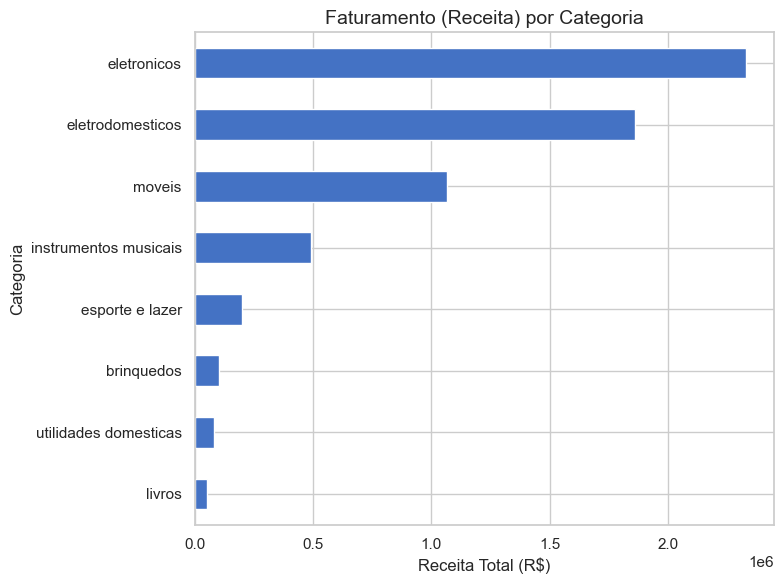

In [190]:
# Bloco COMPLETO corrigido para Faturamento por Categoria
plt.figure(figsize=(8, 6))

# 1. Ordenamos pelo valor do faturamento
# 2. Definimos a categoria como índice (para o plot usar como rótulo Y)
# 3. Selecionamos a coluna de valores e plotamos
(faturamento_categoria
 .sort_values(by="faturamento_total", ascending=True)
 .set_index("categoria_do_produto")["faturamento_total"]
 .plot(kind="barh", color="#4472C4")
)

plt.title("Faturamento (Receita) por Categoria", fontsize=14)
plt.xlabel("Receita Total (R$)")
plt.ylabel("Categoria")
plt.tight_layout()

# SALVAR A IMAGEM
plt.savefig("../images/faturamento_por_categoria.png", dpi=300)
plt.show()

#### 3.2.2 Vendas por categoria (quantidade)

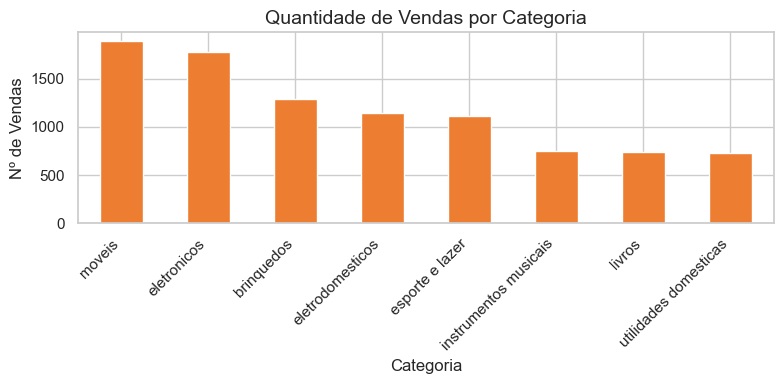

In [ ]:
#Conte quantas vezes cada valor único aparece nesta Series
vendas_categoria = (
    dados["categoria_do_produto"]
    .value_counts()
    .sort_values(ascending=False)
)
vendas_categoria

#A PREPARAÇÃO (Criar a "tela" do gráfico)

plt.figure(figsize=(8, 4))
vendas_categoria.plot(kind="bar", color="#ED7D31") # Cor de destaque
plt.title("Quantidade de Vendas por Categoria", fontsize=14)
plt.xlabel("Categoria")
plt.ylabel("Nº de Vendas")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# SALVAR A IMAGEM
plt.savefig("../images/vendas_por_categoria.png", dpi=300)
plt.show()


#### 3.2.3 Produtos mais e menos vendidos

In [168]:
vendas_produto = dados["produto"].value_counts()
#O FILTRO "TOP 10" (Pegar os 10 melhores)
top_10_produtos = vendas_produto.head(10)

#O FILTRO "BOTTOM 10" (Pegar os 10 piores)
bottom_10_produtos = vendas_produto.tail(10)

top_10_produtos

produto
Cômoda                      210
Carrinho controle remoto    206
Micro-ondas                 206
Bateria                     203
Cama king                   201
Secadora de roupas          200
Modelagem preditiva         200
Jogo de panelas             200
Cama box                    199
Blocos de montar            199
Name: count, dtype: int64

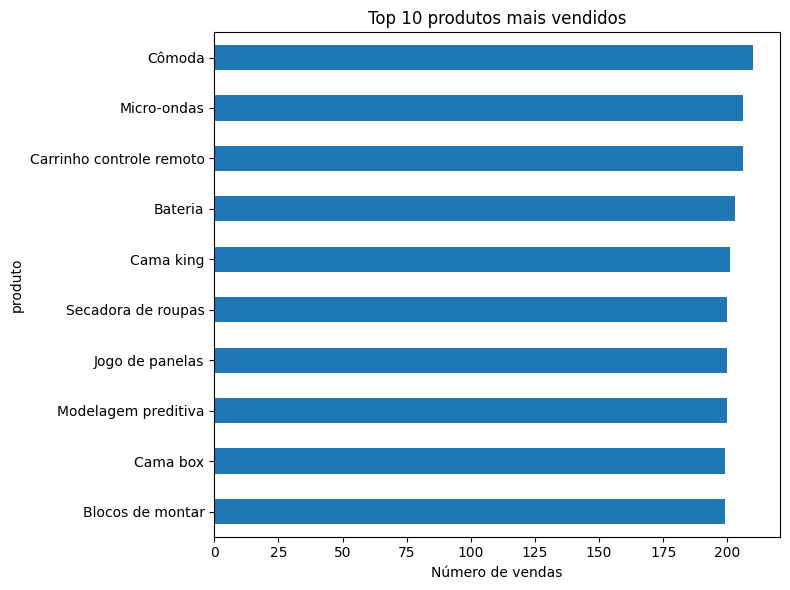

In [169]:
#Gráfico Top 10 Produtos
ax = top_10_produtos.sort_values().plot(
    kind="barh",
    figsize=(8, 6)
)

ax.set_title("Top 10 produtos mais vendidos")
ax.set_xlabel("Número de vendas")
plt.tight_layout()
plt.show()


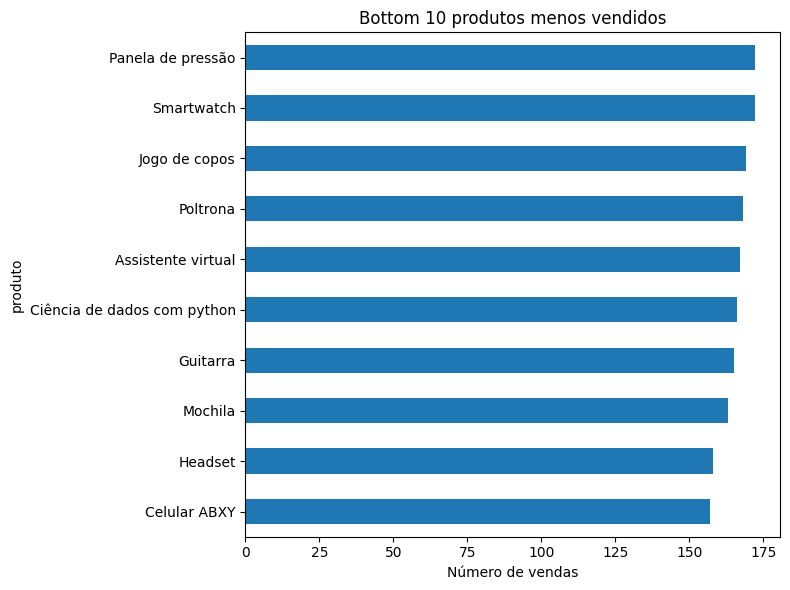

In [170]:
#Gráfico Bottom 10 PRodutos
ax = bottom_10_produtos.sort_values().plot(
    kind="barh",
    figsize=(8, 6)
)

ax.set_title("Bottom 10 produtos menos vendidos")
ax.set_xlabel("Número de vendas")
plt.tight_layout()
plt.show()

### 3.3 Experiência do cliente (avaliação por loja)

Aqui vamos analisar a **avaliação média** que os clientes dão para cada loja.

#### 3.3.1 Avaliação média por loja

In [171]:
avaliacao_media_loja = (
    dados
    .groupby("loja", as_index=False)["avaliação_da_compra"]
    .mean()
    .rename(columns={"avaliação_da_compra": "avaliacao_media"})
)

avaliacao_media_loja["avaliacao_media"] = avaliacao_media_loja["avaliacao_media"].round(2)

avaliacao_media_loja


,loja,avaliacao_media
0,Loja 1,3.98
1,Loja 2,4.04
2,Loja 3,4.05
3,Loja 4,4.00


<Figure size 800x400 with 0 Axes>

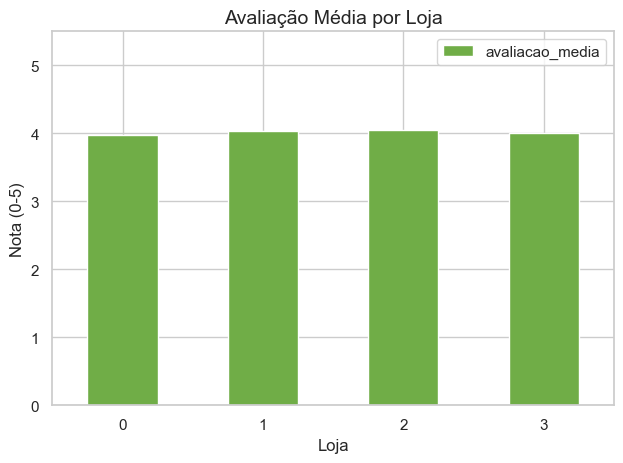

In [186]:

plt.figure(figsize=(8, 4))
avaliacao_media_loja.plot(kind="bar", color="#70AD47") # Cor verde para "bom"
plt.title("Avaliação Média por Loja", fontsize=14)
plt.xlabel("Loja")
plt.ylabel("Nota (0-5)")
plt.ylim(0, 5.5) # Dá um respiro no topo
plt.xticks(rotation=0)
plt.tight_layout()

# SALVAR A IMAGEM
plt.savefig("../images/avaliacao_media_loja.png", dpi=300)
plt.show()

### 3.4 Logística (frete médio por loja)

Aqui vamos analisar o **frete médio** cobrado em cada loja.

#### 3.4.1 Frete médio por loja

In [173]:
frete_medio_loja = (
    dados
    .groupby("loja", as_index=False)["frete"]
    .mean()
    .rename(columns={"frete": "frete_medio"})
)

frete_medio_loja["frete_medio"] = frete_medio_loja["frete_medio"].round(2)

frete_medio_loja


,loja,frete_medio
0,Loja 1,34.69
1,Loja 2,33.62
2,Loja 3,33.07
3,Loja 4,31.28


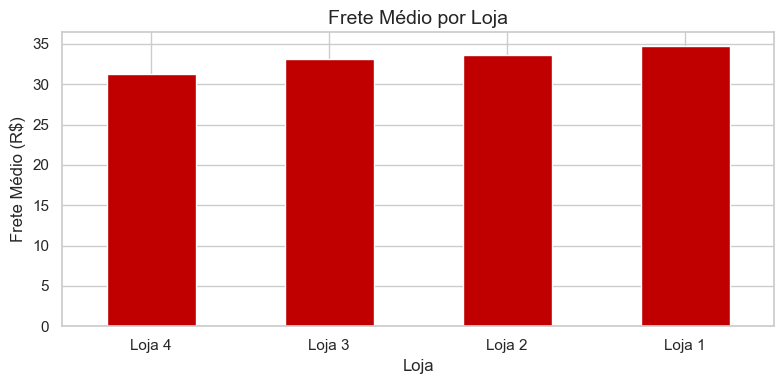

In [187]:
# ... seu código de plotagem anterior ...
plt.figure(figsize=(8, 4))
frete_medio.plot(kind="bar", color="#C00000") # Cor vermelha para "custo"
plt.title("Frete Médio por Loja", fontsize=14)
plt.xlabel("Loja")
plt.ylabel("Frete Médio (R$)")
plt.xticks(rotation=0)
plt.tight_layout()

# SALVAR A IMAGEM
plt.savefig("../images/frete_medio_loja.png", dpi=300)
plt.show()

## 4. Comparativo consolidado entre lojas

In [175]:
# 4. Comparativo consolidado entre lojas

# Garante que a coluna 'receita' existe
if "receita" not in dados.columns:
    dados["receita"] = dados["preço"] + dados["frete"]

resumo_lojas = dados.groupby("loja").agg(
    faturamento_total = ("receita", "sum"),
    avaliacao_media   = ("avaliação_da_compra", "mean"),
    frete_medio       = ("frete", "mean"),
    vendas_total      = ("produto", "count")
)

# Arredondar valores financeiros
resumo_lojas["faturamento_total"] = resumo_lojas["faturamento_total"].round(2)
resumo_lojas["frete_medio"] = resumo_lojas["frete_medio"].round(2)

# Ticket médio (faturamento / número de vendas)
resumo_lojas["ticket_medio"] = (
    resumo_lojas["faturamento_total"] / resumo_lojas["vendas_total"]
).round(2)

resumo_lojas

,faturamento_total,avaliacao_media,frete_medio,vendas_total,ticket_medio
loja,,,,,
Loja 1,1616347.09,3.976685,34.69,2359,685.18
Loja 2,1567773.22,4.037304,33.62,2359,664.59
Loja 3,1542047.69,4.048326,33.07,2359,653.69
Loja 4,1458253.46,3.995759,31.28,2358,618.43


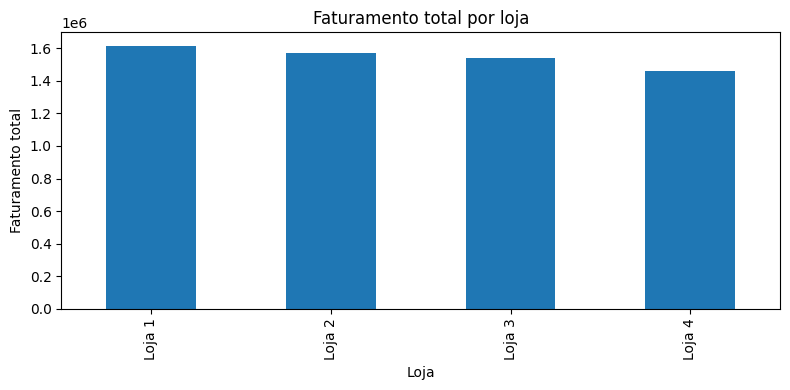

In [176]:
plt.figure(figsize=(8,4))
resumo_lojas["faturamento_total"].plot(kind="bar")
plt.title("Faturamento total por loja")
plt.xlabel("Loja")
plt.ylabel("Faturamento total")
plt.tight_layout()
plt.show()

## 5. Recomendação final para o Senhor João

A partir dos KPIs calculados (faturamento, avaliação média, frete e ticket médio), temos o seguinte resumo por loja:

- **Loja 1** – maior faturamento total da rede, porém com avaliação um pouco abaixo das Lojas 2 e 3.
- **Loja 2** – bom faturamento e avaliação média alta.
- **Loja 3** – faturamento próximo ao da Loja 2 e a melhor avaliação média entre as lojas.
- **Loja 4** – menor faturamento total e menor ticket médio, além de avaliação média inferior às Lojas 2 e 3.

Embora a **Loja 4** tenha o frete médio mais barato, ela é a unidade que **menos contribui para o faturamento total** e que gera a **menor receita por venda**.

Do ponto de vista financeiro e estratégico, vender a Loja 4:

- causa o **menor impacto negativo** na receita total da rede;
- permite manter no portfólio as lojas com melhor combinação de faturamento e satisfação dos clientes.

> ✅ **Recomendação:**  
> O Senhor João deve **vender a Loja 4** e manter as Lojas 1, 2 e 3 operando, pois elas apresentam melhor equilíbrio entre receita e percepção dos clientes.